## Installing Deepchem and Loading Dataset

In [1]:
# Installing Deepchem
!pip install --pre deepchem
# Import deepchem just to check the version
import deepchem
#deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 34.7 MB/s eta 0:00:00


In [2]:
# Importing required libraries and its utilities
import numpy as np

np.random.seed(123)
import tensorflow as tf

tf.random.set_seed(123)
import deepchem as dc
from deepchem.molnet import load_tox21
from deepchem.models.graph_models import GraphConvModel
from deepchem.data import NumpyDataset
from rdkit import Chem
from deepchem.molnet import load_tox21

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#print(load_tox21.__doc__)
tox21_tasks, tox21_datasets, transformers = load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

[16:34:51] WARNING: not removing hydrogen atom without neighbors
[16:35:23] WARNING: not removing hydrogen atom without neighbors


## Visualizing Compounds from the Database

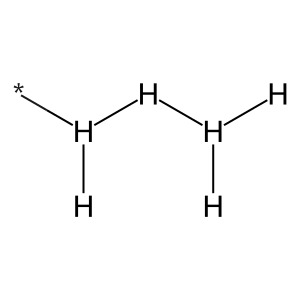

In [5]:
compound_index = 10

# Retrieve compound and its features from dataset
compound = tox21_datasets[0].X[compound_index]
atom_features = compound.get_atom_features()
adjacency = compound.get_adjacency_list()

# Create an RDKit molecule object
mol = Chem.RWMol()

# Add atoms to the molecule
for atom_feat in atom_features:
    atomic_number = int(atom_feat[0])
    atom = Chem.Atom(atomic_number)
    mol.AddAtom(atom)

# Add bonds to the molecule
bond_indices = set()
for i, neighbors in enumerate(adjacency):
    for j in neighbors:
        if (j, i) not in bond_indices:  # Check if bond already exists
            mol.AddBond(i, j, Chem.BondType.SINGLE)
            bond_indices.add((i, j))


# Convert the molecule to a non-editable RDKit molecule object
molecule = mol.GetMol()


# Generate a 2D depiction of the molecule
img = Chem.Draw.MolToImage(molecule)

# Show the molecule image
img.show()

##Training GCN Model

In [7]:
# Define metric for the model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")

In [8]:
# Define and fit the model
model = GraphConvModel(len(tox21_tasks), batch_size=32, mode='classification')
model.fit(train_dataset, nb_epoch=20)


0.5719635486602783

In [31]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores\t", train_scores['mean-roc_auc_score'])
print("Validation scores\t", valid_scores['mean-roc_auc_score'])

Train scores	 0.92722440155175
Validation scores	 0.7298605947299609


## Predicting Properties of a given molecule

In [22]:
compound_index = 10

compound = tox21_datasets[0].X[compound_index]
compound_batch = np.expand_dims(compound, axis=0)
predictions = model.predict_on_batch(compound_batch)
compound_predictions = predictions[0]

In [19]:
for task_name, predicted_value in zip(tox21_tasks, compound_predictions):
    print(f"{task_name}: {predicted_value}")

NR-AR: [0.950151 0.049849]
NR-AR-LBD: [9.9951524e-01 4.8475227e-04]
NR-AhR: [0.98944294 0.01055709]
NR-Aromatase: [9.9942887e-01 5.7099771e-04]
NR-ER: [0.76547366 0.2345264 ]
NR-ER-LBD: [0.98578155 0.0142184 ]
NR-PPAR-gamma: [9.9915034e-01 8.4955792e-04]
SR-ARE: [0.94233894 0.05766105]
SR-ATAD5: [9.9948597e-01 5.1402702e-04]
SR-HSE: [0.99505603 0.00494393]
SR-MMP: [0.9950198  0.00498021]
SR-p53: [9.991911e-01 8.088617e-04]


In [21]:
# Print out properties that molecule tested positive for
# ie. properties where prediction above threshold

taskval = 0
threshold = 0.1

for val in compound_predictions:
  if(val[1]>threshold):
    print(tox21_tasks[taskval])
  taskval = taskval + 1

NR-ER


In the Tox21 dataset, the task labels indicate the activity of compounds against certain biological targets or assays, but it doesn't necessarily imply toxicity in a general sense. The goal of the dataset is to evaluate the potential effects of compounds on various biological processes and provide information relevant to drug discovery, environmental health, and chemical safety.

In the context of the 'NR-AR' task, a predicted value of 1 indicates that the compound is predicted to be active in binding to the androgen receptor. This means that the compound has a higher likelihood of interacting with the receptor and potentially affecting the related biological pathway. However, whether this activity is considered toxic or not depends on the specific application, desired effects, and the potential consequences of modulating the androgen receptor pathway.
